# CRAFT fine tuning Demo with unbalanced linearized conversation data

This example notebook shows how a pre-trained CRAFT model can be fine tuned on the linearized form of a standard conversation corpus, to predict future derailment. This example is an adaptation of the demo notebook provided by the authors of the "Trouble on the Horizon" paper, and uses ConvoKit's version of the labeled Wikiconv corpus.

In [1]:
# start by installing ConvoKit on the colab VM
!pip install -q convokit

     |████████████████████████████████| 167 kB 9.0 MB/s 
     |████████████████████████████████| 6.0 MB 26.9 MB/s 
     |████████████████████████████████| 1.5 MB 32.4 MB/s 
     |████████████████████████████████| 235 kB 50.7 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 170 kB 40.8 MB/s 
     |████████████████████████████████| 749 kB 47.7 MB/s 
     |████████████████████████████████| 181 kB 43.3 MB/s 
     |████████████████████████████████| 451 kB 47.4 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 10.1 MB 25.7 MB/s 
     |████████████████████████████████| 628 kB 18.9 MB/s 


In [2]:
# import necessary libraries, including convokit
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import requests
import os
import sys
import random
import unicodedata
import itertools
from urllib.request import urlretrieve
from convokit import download, Corpus, Conversation
%matplotlib inline

In [3]:
# define globals and constants

MAX_LENGTH = 80  # Maximum sentence length (number of tokens) to consider

# configure model
num_classes = 2
hidden_size = 500
encoder_n_layers = 2
context_encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
labeled_learning_rate = 1e-5
decoder_learning_ratio = 5.0
print_every = 10

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3  # Unknown word token

# model download paths
WORD2INDEX_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/word2index.json"
INDEX2WORD_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/index2word.json"
MODEL_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/craft_full.tar"

# confidence score threshold for declaring a positive prediction.
# this value was previously learned on the validation set.
FORECAST_THRESH = 0.570617

## Part 1: set up data conversion utilities

We begin by setting up some helper functions and classes for converting conversational text data into a torch-friendly Tensor format. Note that these low-level routines are largely taken from the [PyTorch seq2seq chatbot tutorial](https://pytorch.org/tutorials/beginner/chatbot_tutorial.html).

In [4]:
class Voc:
    """A class for representing the vocabulary used by a CRAFT model"""

    def __init__(self, name, word2index=None, index2word=None):
        self.name = name
        self.trimmed = False if not word2index else True # if a precomputed vocab is specified assume the user wants to use it as-is
        self.word2index = word2index if word2index else {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = index2word if index2word else {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4 if not index2word else len(index2word)  # Count SOS, EOS, PAD, UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

# Create a Voc object from precomputed data structures
def loadPrecomputedVoc(corpus_name, word2index_url, index2word_url):
    # load the word-to-index lookup map
    r = requests.get(word2index_url)
    word2index = r.json()
    # load the index-to-word lookup map
    r = requests.get(index2word_url)
    index2word = r.json()
    return Voc(corpus_name, word2index, index2word)

In [5]:
# Helper functions for preprocessing and tokenizing text

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Tokenize the string using NLTK
def tokenize(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(pattern=r'\w+|[^\w\s]')
    # simplify the problem space by considering only ASCII data
    cleaned_text = unicodeToAscii(text.lower())

    # if the resulting string is empty, nothing else to do
    if not cleaned_text.strip():
        return []
    
    return tokenizer.tokenize(cleaned_text)

# Given a ConvoKit conversation, preprocess each utterance's text by tokenizing and truncating.
# Returns the processed dialog entry where text has been replaced with a list of
# tokens, each no longer than MAX_LENGTH - 1 (to leave space for the EOS token)
# This function, in combination with the following function handles the linearization of conversations
def processDialog(voc, dialog):
    processed = []
    for linear_dialog in dialog.get_root_to_leaf_paths():
        processed_linear_dialog = []
        for utterance in linear_dialog:
            tokens = tokenize(utterance.text)
            # replace out-of-vocabulary tokens
            for i in range(len(tokens)):
                if tokens[i] not in voc.word2index:
                    tokens[i] = "UNK"
            processed_linear_dialog.append({"tokens": tokens, "is_attack": int(utterance.meta['comment_has_personal_attack']), "id": utterance.id})
        processed.append(processed_linear_dialog)
    return processed

# Load context-reply pairs from the Corpus, optionally filtering to only conversations
# from the specified split (train, val, or test).
# Each conversation, which has N comments (not including the section header) will
# get converted into N-1 comment-reply pairs, one pair for each reply 
# (the first comment does not reply to anything).
# Each comment-reply pair is a tuple consisting of the conversational context
# (that is, all comments prior to the reply), the reply itself, the label (that
# is, whether the reply contained a derailment event), and the comment ID of the
# reply (for later use in re-joining with the ConvoKit corpus).
# The function returns a list of such pairs.
# This function, in combination with the previous function handles the linearization of conversations
def loadPairs(voc, corpus, split=None, last_only=False):
    pairs = []
    conv_idx = 0
    all_conversations = []
    for convo in corpus.iter_conversations():
        # consider only conversations in the specified split of the data
        integrity = convo.check_integrity()
        if (split is None or convo.meta['split'] == split) and integrity:
            dialog_list = processDialog(voc, convo)
            for dialog in dialog_list:
                iter_range = range(1, len(dialog)) if not last_only else [len(dialog)-1]
                conversation_indxs = []
                for idx in iter_range:
                    reply = dialog[idx]["tokens"][:(MAX_LENGTH-1)]
                    label = dialog[idx]["is_attack"]
                    comment_id = dialog[idx]["id"]
                    # gather as context all utterances preceding the reply
                    context = [u["tokens"][:(MAX_LENGTH-1)] for u in dialog[:idx]]
                    pairs.append((context, reply, label, comment_id))
                    conversation_indxs.append(conv_idx)
                    conv_idx += 1
                all_conversations.append(conversation_indxs)
    return pairs, all_conversations

In [6]:
# Helper functions for turning dialog and text sequences into tensors, and manipulating those tensors

def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Takes a batch of dialogs (lists of lists of tokens) and converts it into a
# batch of utterances (lists of tokens) sorted by length, while keeping track of
# the information needed to reconstruct the original batch of dialogs
def dialogBatch2UtteranceBatch(dialog_batch):
    utt_tuples = [] # will store tuples of (utterance, original position in batch, original position in dialog)
    for batch_idx in range(len(dialog_batch)):
        dialog = dialog_batch[batch_idx]
        for dialog_idx in range(len(dialog)):
            utterance = dialog[dialog_idx]
            utt_tuples.append((utterance, batch_idx, dialog_idx))
    # sort the utterances in descending order of length, to remain consistent with pytorch padding requirements
    utt_tuples.sort(key=lambda x: len(x[0]), reverse=True)
    # return the utterances, original batch indices, and original dialog indices as separate lists
    utt_batch = [u[0] for u in utt_tuples]
    batch_indices = [u[1] for u in utt_tuples]
    dialog_indices = [u[2] for u in utt_tuples]
    return utt_batch, batch_indices, dialog_indices

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch, already_sorted=False):
    if not already_sorted:
        pair_batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_batch, output_batch, label_batch, id_batch = [], [], [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
        label_batch.append(pair[2])
        id_batch.append(pair[3])
    dialog_lengths = torch.tensor([len(x) for x in input_batch])
    input_utterances, batch_indices, dialog_indices = dialogBatch2UtteranceBatch(input_batch)
    inp, utt_lengths = inputVar(input_utterances, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    label_batch = torch.FloatTensor(label_batch) if label_batch[0] is not None else None
    return inp, dialog_lengths, utt_lengths, batch_indices, dialog_indices, label_batch, id_batch, output, mask, max_target_len

def batchIterator(voc, source_data, batch_size, shuffle=True):
    cur_idx = 0
    if shuffle:
        random.shuffle(source_data)
    while True:
        if cur_idx >= len(source_data):
            cur_idx = 0
            if shuffle:
                random.shuffle(source_data)
        batch = source_data[cur_idx:(cur_idx+batch_size)]
        # the true batch size may be smaller than the given batch size if there is not enough data left
        true_batch_size = len(batch)
        # ensure that the dialogs in this batch are sorted by length, as expected by the padding module
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        # for analysis purposes, get the source dialogs and labels associated with this batch
        batch_dialogs = [x[0] for x in batch]
        batch_labels = [x[2] for x in batch]
        # convert batch to tensors
        batch_tensors = batch2TrainData(voc, batch, already_sorted=True)
        yield (batch_tensors, batch_dialogs, batch_labels, true_batch_size) 
        cur_idx += batch_size

## Part 2: load the data

Now we load the labeled Wikiconv corpus from ConvoKit, and run some transformations to prepare it for use with PyTorch

In [7]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
#corpus_for_extended_model = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

# Rough cells for data labeling

The following 3 cells can be used for data labeling. We can 100% do this before linearizing the conversations to avoid redundancy.

In [8]:
# Both corpuses we are interested in already have train/val/test splits. We can use this while labeling to make sure we label conversations belonging to all 3 categories
#corpus.filter_conversations_by(lambda convo: convo.meta['split'] == 'train')

In [9]:
#convos_evaluated = []

In [10]:
# here is rough code to assign labels into the data. We may use this, we may use something else. Regardless we will
# WANT TO BE SURE WE SAVE AND DOWNLOAD any work we run on colab
#last_conversation = 0
#inp = ''
#while inp != 'stop':
#  convo = corpus.get_conversation(corpus.get_conversation_ids()[last_conversation])
#  #convo.print_conversation_structure(lambda utt: utt.id + "   " + utt.text[:50] + "\n")
#  utterances = convo.get_utterance_ids()
#  while len(utterances) > 20:
#    last_conversation += 1
#    convo = corpus.get_conversation(corpus.get_conversation_ids()[last_conversation])
#    utterances = convo.get_utterance_ids()
#  for utt in utterances:
#    utt_data = corpus.get_utterance(utt)
#    inp = ''
#    while inp not in ['stop', 'y', 'n', 'r']:
#      print(utt_data.text)
#      inp = input(utt+'  '+utt_data.speaker.id+'  Personal Attack?: ')
#      if inp == 'y':
#        utt_data.meta['comment_has_personal_attack'] = True
#      elif inp == 'n':
#        utt_data.meta['comment_has_personal_attack'] = False
#    if inp == 'stop':
#      break
#  convos_evaluated.append(convon)
#  last_conversation += 1
#  print('Currently in conversation ',last_conversation)

In [11]:
# let's check some quick stats to verify that the corpus loaded correctly
print(len(corpus.get_utterance_ids()))
print(len(corpus.get_usernames()))
print(len(corpus.get_conversation_ids()))

30021
8069
4188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: get_usernames() is deprecated and will be removed in a future release. Use get_speaker_ids() instead.


In [12]:
# Let's also take a look at some example data to see what kinds of information/metadata are available to us
print(list(corpus.iter_conversations())[0].__dict__)
print(list(corpus.iter_utterances())[0])

{'obj_type': 'conversation', '_owner': <convokit.model.corpus.Corpus object at 0x7faa51238810>, 'meta': {'page_title': 'User talk:2005', 'page_id': 1003212, 'pair_id': '143890867.11926.11926', 'conversation_has_personal_attack': False, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'train'}, '_id': '146743638.12652.12652', 'vectors': [], '_utterance_ids': ['146743638.12652.12652', '146743638.12667.12652', '146842219.12874.12874', '146860774.13072.13072'], '_speaker_ids': None, 'tree': None}
Utterance(id: '146743638.12652.12652', conversation_id: 146743638.12652.12652, reply-to: None, speaker: Speaker(id: Sirex98, vectors: [], meta: {}), timestamp: 1185295934.0, text: '== [WIKI_LINK: WP:COMMONNAME] ==\n', vectors: [], meta: {'is_section_header': True, 'comment_has_personal_attack': False, 'toxicity': 0, 'parsed': [{'rt': 3, 'toks': [{'tok': '=', 'tag': 'NFP', 'dep': 'punct', 'up': 3, 'dn': []}, {'tok': '=', 'tag': 'LS', 'dep': 'punct', 'up': 3, 'dn': []}, {

Now we can use the utilities defined in Part 1 to convert the ConvoKit conversational data into a tokenized form that can be straightforwardly turned into Tensors later.

In [13]:
# First, we need to build the vocabulary so that we know how to map tokens to tensor indicies.
# For the sake of replicating the paper results, we will load the pre-computed vocabulary objects used in the paper.
voc = loadPrecomputedVoc("wikiconv", WORD2INDEX_URL, INDEX2WORD_URL)

In [14]:
# Inspect the Voc object to make sure it loaded correctly
print(voc.num_words) # expected vocab size is 50004: it was built using a fixed vocab size of 50k plus 4 spots for special tokens PAD, SOS, EOS, and UNK.
print(list(voc.word2index.items())[:10])
print(list(voc.index2word.items())[:10])

50004
[('UNK', 3), ('.', 4), ('the', 5), ("'", 6), (',', 7), ('to', 8), ('i', 9), ('of', 10), ('a', 11), ('and', 12)]
[('0', 'PAD'), ('1', 'SOS'), ('2', 'EOS'), ('3', 'UNK'), ('4', '.'), ('5', 'the'), ('6', "'"), ('7', ','), ('8', 'to'), ('9', 'i')]


In [15]:
# Convert the test set data into a list of input/label pairs. Each input will represent the conversation as a list of lists of tokens.
train_pairs = loadPairs(voc, corpus, "train", last_only=True)[0]
val_pairs = loadPairs(voc, corpus, "val", last_only=True)[0]
test_pairs, test_indxs = loadPairs(voc, corpus, "test")

Streaming output truncated to the last 5000 lines.
Checking reply-to chain of Conversation 234044712.9032.9032
No issues found.

Checking reply-to chain of Conversation 269894650.1070.1070
No issues found.

Checking reply-to chain of Conversation 331652375.7889.7889
No issues found.

Checking reply-to chain of Conversation 124154930.215277.215211
No issues found.

Checking reply-to chain of Conversation 124113023.188154.188154
No issues found.

Checking reply-to chain of Conversation 692819984.2913.2913
No issues found.

Checking reply-to chain of Conversation 844595084.6611.6611
No issues found.

Checking reply-to chain of Conversation 204198724.11060.11060
No issues found.

Checking reply-to chain of Conversation 204031305.3894.3894
No issues found.

Checking reply-to chain of Conversation 62900025.41968.41968
No issues found.

Checking reply-to chain of Conversation 62890334.37191.37191
No issues found.

Checking reply-to chain of Conversation 12187886.141625.141625
No issues found.

In [16]:
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))

6332
2110
5235


In [17]:
# Validate the conversion by checking data size and some samples
print(len(test_pairs))
for p in test_pairs[:8]:
    print(p)

5235
([['=', '=', 'UNK', '=', '=']], ['i', 'was', 'a', 'bit', 'disgruntled', 'you', 'recently', 'deleted', 'my', 'article', 'on', 'UNK', ',', 'especially', 'just', 'after', 'it', 'had', 'been', 'patrolled', '.', 'i', 'am', 'a', 'user', 'of', 'the', 'site', 'who', 'was', 'interested', 'in', 'its', 'message', 'and', 'felt', 'compelled', 'to', 'look', 'further', 'into', 'it', '(', 'seriously', ',', 'my', 'sources', 'are', 'the', 'first', 'couple', 'things', 'that', 'popped', 'up', 'after', 'a', 'google', 'search', ')', '.', 'i', 'am', 'a', 'bit', 'confused', 'why', 'a', 'well', 'written', 'and', 'documented', 'article', '(', 'my', 'first', ')', 'about', 'an'], 0, '240149353.16340.16332')
([['=', '=', 'UNK', '=', '='], ['i', 'was', 'a', 'bit', 'disgruntled', 'you', 'recently', 'deleted', 'my', 'article', 'on', 'UNK', ',', 'especially', 'just', 'after', 'it', 'had', 'been', 'patrolled', '.', 'i', 'am', 'a', 'user', 'of', 'the', 'site', 'who', 'was', 'interested', 'in', 'its', 'message', 'an

## Part 3: define the model

Next, we need to set up the individual components of the CRAFT framework: the utterance encoder, the context encoder, and the classification head (since we are only running inference on an already-trained model, we do not need to define the decoder here). Each component will be defined as a PyTorch `nn.Module`.

In [18]:
class EncoderRNN(nn.Module):
    """This module represents the utterance encoder component of CRAFT, responsible for creating vector representations of utterances"""
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

class ContextEncoderRNN(nn.Module):
    """This module represents the context encoder component of CRAFT, responsible for creating an order-sensitive vector representation of conversation context"""
    def __init__(self, hidden_size, n_layers=1, dropout=0):
        super(ContextEncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        # only unidirectional GRU for context encoding
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=False)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(input_seq, input_lengths.cpu())
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # return output and final hidden state
        return outputs, hidden

class SingleTargetClf(nn.Module):
    """This module represents the CRAFT classifier head, which takes the context encoding and uses it to make a forecast"""
    def __init__(self, hidden_size, dropout=0.1):
        super(SingleTargetClf, self).__init__()
        
        self.hidden_size = hidden_size
        
        # initialize classifier
        self.layer1 = nn.Linear(hidden_size, hidden_size)
        self.layer1_act = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.layer2_act = nn.LeakyReLU()
        self.clf = nn.Linear(hidden_size // 2, num_classes) ############# changed 1 to 3 Number of output classes
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, encoder_outputs, encoder_input_lengths):
        # from stackoverflow (https://stackoverflow.com/questions/50856936/taking-the-last-state-from-bilstm-bigru-in-pytorch)
        # First we unsqueeze seqlengths two times so it has the same number of
        # of dimensions as output_forward
        # (batch_size) -> (1, batch_size, 1)
        lengths = encoder_input_lengths.unsqueeze(0).unsqueeze(2)
        # Then we expand it accordingly
        # (1, batch_size, 1) -> (1, batch_size, hidden_size) 
        lengths = lengths.expand((1, -1, encoder_outputs.size(2)))

        # take only the last state of the encoder for each batch
        last_outputs = torch.gather(encoder_outputs, 0, lengths-1).squeeze()
        # forward pass through hidden layers
        layer1_out = self.layer1_act(self.layer1(self.dropout(last_outputs)))
        layer2_out = self.layer2_act(self.layer2(self.dropout(layer1_out)))
        # compute and return logits
        logits = self.clf(self.dropout(layer2_out)).squeeze()
        return logits

class Predictor(nn.Module):
    """This helper module encapsulates the CRAFT pipeline, defining the logic of passing an input through each consecutive sub-module."""
    def __init__(self, encoder, context_encoder, classifier):
        super(Predictor, self).__init__()
        self.encoder = encoder
        self.context_encoder = context_encoder
        self.classifier = classifier
        
    def forward(self, input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length):
        # Forward input through encoder model
        _, utt_encoder_hidden = self.encoder(input_batch, utt_lengths)
        
        # Convert utterance encoder final states to batched dialogs for use by context encoder
        context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
        
        # Forward pass through context encoder
        context_encoder_outputs, context_encoder_hidden = self.context_encoder(context_encoder_input, dialog_lengths)
        
        # Forward pass through classifier to get prediction logits
        logits = self.classifier(context_encoder_outputs, dialog_lengths)
        
        # Apply sigmoid activation
        predictions = F.softmax(logits, dim=1) ################### changed F.sigmoid(logits) to F.softmax(logits, dim=1)
        return predictions

def makeContextEncoderInput(utt_encoder_hidden, dialog_lengths, batch_size, batch_indices, dialog_indices):
    """The utterance encoder takes in utterances in combined batches, with no knowledge of which ones go where in which conversation.
       Its output is therefore also unordered. We correct this by using the information computed during tensor conversion to regroup
       the utterance vectors into their proper conversational order."""
    # first, sum the forward and backward encoder states
    utt_encoder_summed = utt_encoder_hidden[-2,:,:] + utt_encoder_hidden[-1,:,:]
    # we now have hidden state of shape [utterance_batch_size, hidden_size]
    # split it into a list of [hidden_size,] x utterance_batch_size
    last_states = [t.squeeze() for t in utt_encoder_summed.split(1, dim=0)]
    
    # create a placeholder list of tensors to group the states by source dialog
    states_dialog_batched = [[None for _ in range(dialog_lengths[i])] for i in range(batch_size)]
    
    # group the states by source dialog
    for hidden_state, batch_idx, dialog_idx in zip(last_states, batch_indices, dialog_indices):
        states_dialog_batched[batch_idx][dialog_idx] = hidden_state
        
    # stack each dialog into a tensor of shape [dialog_length, hidden_size]
    states_dialog_batched = [torch.stack(d) for d in states_dialog_batched]
    
    # finally, condense all the dialog tensors into a single zero-padded tensor
    # of shape [max_dialog_length, batch_size, hidden_size]
    return torch.nn.utils.rnn.pad_sequence(states_dialog_batched)

## Part 4: define the evaluation procedure

We're almost ready to run! The last component we need is some code for actually running the data through the full CRAFT pipeline. This includes actually converting the text input into tensors (we use the utilities defined in Part 1 to do this) then passing the resulting tensors through each CRAFT module batch-by-batch.

In [19]:
def train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
          encoder, context_encoder, attack_clf,                                                                    # network arguments
          encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
          batch_size, clip, max_length=MAX_LENGTH):                                                                # misc arguments

    # Zero gradients
    encoder_optimizer.zero_grad()
    context_encoder_optimizer.zero_grad()
    attack_clf_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    labels = labels.to(device)

    # Forward pass through utterance encoder
    _, utt_encoder_hidden = encoder(input_variable, utt_lengths)
    
    # Convert utterance encoder final states to batched dialogs for use by context encoder
    context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
    
    # Forward pass through context encoder
    context_encoder_outputs, _ = context_encoder(context_encoder_input, dialog_lengths)

    # Forward pass through classifier to get prediction logits
    logits = attack_clf(context_encoder_outputs, dialog_lengths)
    
    # Calculate loss
    loss = F.cross_entropy(logits, labels.long()) ######## from binary_cross_entropy_with_logits

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(attack_clf.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    context_encoder_optimizer.step()
    attack_clf_optimizer.step()

    return loss.item()

def validate(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    # containers for full prediction results so we can compute accuracy at the end
    all_preds = []
    all_labels = []
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)
        # aggregate results for computing accuracy at the end
        all_preds += [p.item() for p in predictions]
        all_labels += [l.item() for l in labels]
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    # compute and return the accuracy
    return (np.asarray(all_preds) == np.asarray(all_labels)).mean()

def trainIters(voc, pairs, val_pairs, encoder, context_encoder, attack_clf,
               encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
               n_iteration, batch_size, print_every, validate_every, clip):
    
    # create a batch iterator for training data
    batch_iterator = batchIterator(voc, pairs, batch_size)
    
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    # Training loop
    print("Training...")
    # keep track of best validation accuracy - only save when we have a model that beats the current best
    best_acc = 0
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch, training_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, _, target_variable, mask, max_target_len = training_batch
        dialog_lengths_list = [len(x) for x in training_dialogs]

        # Run a training iteration with batch
        loss = train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
                     encoder, context_encoder, attack_clf,                                                                    # network arguments
                     encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
                     true_batch_size, clip)                                                                                   # misc arguments
        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Evaluate on validation set
        if (iteration % validate_every == 0):
            print("Validating!")
            # put the network components into evaluation mode
            encoder.eval()
            context_encoder.eval()
            attack_clf.eval()
            
            predictor = Predictor(encoder, context_encoder, attack_clf)
            accuracy = validate(val_pairs, encoder, context_encoder, predictor, voc, batch_size, device)
            print("Validation set accuracy: {:.2f}%".format(accuracy * 100))

            # keep track of our best model so far
            if accuracy > best_acc:
                print("Validation accuracy better than current best; saving model...")
                best_acc = accuracy
                torch.save({
                    'iteration': iteration,
                    'en': encoder.state_dict(),
                    'ctx': context_encoder.state_dict(),
                    'atk_clf': attack_clf.state_dict(),
                    'en_opt': encoder_optimizer.state_dict(),
                    'ctx_opt': context_encoder_optimizer.state_dict(),
                    'atk_clf_opt': attack_clf_optimizer.state_dict(),
                    'loss': loss,
                    'voc_dict': voc.__dict__,
                    'embedding': embedding.state_dict()
                }, "finetuned_model.tar")
            
            # put the network components back into training mode
            encoder.train()
            context_encoder.train()
            attack_clf.train()

In [20]:
def evaluateBatch(encoder, context_encoder, predictor, voc, input_batch, dialog_lengths, 
                  dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, device, max_length=MAX_LENGTH):
    # Set device options
    input_batch = input_batch.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    # Predict future attack using predictor
    scores = predictor(input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length)
    predictions = (scores.argmax(dim=1)).float() ############ scores > 0.5 to scores.argmax(dim=1)
    return predictions, scores

def evaluateDataset(dataset, conv_idxs, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    output_df = {
        "id": [],
        "prediction": [],
        "score": []
    }
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)

        # format the output as a dataframe (which we can later re-join with the corpus)
        for i in range(true_batch_size):
            convo_id = convo_ids[i]
            pred = predictions[i].item()
            score = scores[i,1].item() ######################### grab position 1
            output_df["id"].append((iteration-1)*batch_size + i)
            output_df["prediction"].append(pred)
            output_df["score"].append(score)
                
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    return pd.DataFrame(output_df).set_index("id")

## Part 5: build, fine tune, and run the model

We finally have all the components we need! Now we can instantiate the CRAFT model components, load the trained weights, fine tune them with the evaluation head, and run the evaluation.

In [21]:
# Fix random state (affect native Python code only, does not affect PyTorch and hence does not guarantee reproducibility)
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cuda')

print("Loading saved parameters...")
if not os.path.isfile("model.tar"):
    print("\tDownloading trained CRAFT...")
    urlretrieve(MODEL_URL, "model.tar")
    print("\t...Done!")
checkpoint = torch.load("model.tar")
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
#checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Compute the number of training iterations we will need in order to achieve the number of epochs specified in the settings at the start of the notebook
n_iter_per_epoch = len(train_pairs) // batch_size + int(len(train_pairs) % batch_size == 1)
n_iteration = n_iter_per_epoch * 30 #finetune_epochs

# Put dropout layers in train mode
encoder.train()
context_encoder.train()
attack_clf.train()

# Initialize optimizers
print('Building optimizers...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=labeled_learning_rate)
context_encoder_optimizer = optim.Adam(context_encoder.parameters(), lr=labeled_learning_rate)
attack_clf_optimizer = optim.Adam(attack_clf.parameters(), lr=labeled_learning_rate)

# Run training iterations, validating after every epoch
print("Starting Training!")
print("Will train for {} iterations".format(n_iteration))
trainIters(voc, train_pairs, val_pairs, encoder, context_encoder, attack_clf,
           encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
           n_iteration, batch_size, print_every, n_iter_per_epoch, clip)

Loading saved parameters...
	...Done!
Building encoders, decoder, and classifier...
Models built and ready to go!
Building optimizers...
Starting Training!
Will train for 2940 iterations
Initializing ...
Training...
Iteration: 10; Percent complete: 0.3%; Average loss: 0.6947
Iteration: 20; Percent complete: 0.7%; Average loss: 0.6805
Iteration: 30; Percent complete: 1.0%; Average loss: 0.6673
Iteration: 40; Percent complete: 1.4%; Average loss: 0.6596
Iteration: 50; Percent complete: 1.7%; Average loss: 0.6454
Iteration: 60; Percent complete: 2.0%; Average loss: 0.6394
Iteration: 70; Percent complete: 2.4%; Average loss: 0.6102
Iteration: 80; Percent complete: 2.7%; Average loss: 0.5862
Iteration: 90; Percent complete: 3.1%; Average loss: 0.5720
Validating!
Iteration: 1; Percent complete: 3.0%
Iteration: 2; Percent complete: 6.1%
Iteration: 3; Percent complete: 9.1%
Iteration: 4; Percent complete: 12.1%
Iteration: 5; Percent complete: 15.2%
Iteration: 6; Percent complete: 18.2%
Iterati

In [22]:
print('Models built and ready to go!')

# Set dropout layers to eval mode
encoder.eval()
context_encoder.eval()
attack_clf.eval()

# Initialize the pipeline
predictor = Predictor(encoder, context_encoder, attack_clf)

# Run the pipeline!
forecasts_df = evaluateDataset(test_pairs, test_indxs, encoder, context_encoder, predictor, voc, batch_size, device)

Models built and ready to go!
Iteration: 1; Percent complete: 1.2%
Iteration: 2; Percent complete: 2.4%
Iteration: 3; Percent complete: 3.7%
Iteration: 4; Percent complete: 4.9%
Iteration: 5; Percent complete: 6.1%
Iteration: 6; Percent complete: 7.3%
Iteration: 7; Percent complete: 8.5%
Iteration: 8; Percent complete: 9.8%
Iteration: 9; Percent complete: 11.0%
Iteration: 10; Percent complete: 12.2%
Iteration: 11; Percent complete: 13.4%
Iteration: 12; Percent complete: 14.6%
Iteration: 13; Percent complete: 15.9%
Iteration: 14; Percent complete: 17.1%
Iteration: 15; Percent complete: 18.3%
Iteration: 16; Percent complete: 19.5%
Iteration: 17; Percent complete: 20.7%
Iteration: 18; Percent complete: 22.0%
Iteration: 19; Percent complete: 23.2%
Iteration: 20; Percent complete: 24.4%
Iteration: 21; Percent complete: 25.6%
Iteration: 22; Percent complete: 26.8%
Iteration: 23; Percent complete: 28.0%
Iteration: 24; Percent complete: 29.3%
Iteration: 25; Percent complete: 30.5%
Iteration: 2

In [23]:
# Inspect some of the outputs as a sanity-check
forecasts_df.head(20)

,prediction,score
id,,
0,1.0,0.927966
1,0.0,0.153036
2,1.0,0.997703
3,1.0,0.672986
4,0.0,0.004283
5,0.0,0.001043
6,0.0,0.000451
7,0.0,0.000451
8,0.0,0.003634


## Part 6: merge predictions back into corpus and evaluate

Now that the hard part is done, all that is left to do is to evaluate the predictions. Since the predictions are in no particular order, we will first merge each prediction back into the source corpus, and then evaluate each conversation according to the order of utterances within that conversation.

In [24]:
# Finally, we can use the forecast-annotated corpus to compute the forecast accuracy.
# Though we have an individual forecast per utterance, ground truth is at the conversation level:
# either a conversation derails or it does not. Thus, forecast accuracy is computed as follows:
#   - True positives are cases that actually derail, for which the model made at least one positive forecast ANYTIME prior to derailment
#   - False positives are cases that don't derail but for which the model made at least one positive forecast
#   - False negatives are cases that derail but for which the model made no positive forecasts prior to derailment
#   - True negatives are cases that don't derail, for which the model made no positive forecasts
# Note that by construction, the last comment of each conversation is the one marked as derailment, and that our earlier code was therefore
# set up to not look at the last comment, meaning that all forecasts we obtained are forecasts made prior to derailment. This simplifies
# the computation of forecast accuracy as we now do not need to explicitly consider when a forecast was made.

conversational_forecasts_df = {
    "convo_id": [],
    "label": [],
    "score": [],
    "prediction": []
}
i = 0
for convo in test_indxs:
    conversational_forecasts_df['convo_id'].append(i)
    i += 1
    conversational_forecasts_df['label'].append(int(test_pairs[convo[-1]][2]))
    forecast_scores = [forecasts_df.loc[utt].score for utt in convo]
    conversational_forecasts_df['score'] = np.max(forecast_scores)
    conversational_forecasts_df['prediction'].append(int(np.max(forecast_scores) > FORECAST_THRESH))

conversational_forecasts_df = pd.DataFrame(conversational_forecasts_df).set_index("convo_id")
print((conversational_forecasts_df.label == conversational_forecasts_df.prediction).mean())

0.7557692307692307


In [25]:
# in addition to accuracy, we can also consider applying other metrics at the conversation level, such as precision/recall
def get_pr_stats(preds, labels):
    tp = ((labels==1)&(preds==1)).sum()
    fp = ((labels==0)&(preds==1)).sum()
    tn = ((labels==0)&(preds==0)).sum()
    fn = ((labels==1)&(preds==0)).sum()
    print("Precision = {0:.4f}, recall = {1:.4f}".format(tp / (tp + fp), tp / (tp + fn)))
    print("False positive rate =", fp / (fp + tn))
    print("F1 =", 2 / (((tp + fp) / tp) + ((tp + fn) / tp)))

get_pr_stats(conversational_forecasts_df.prediction, conversational_forecasts_df.label)

Precision = 0.2541, recall = 0.2185
False positive rate = 0.13290771909460244
F1 = 0.23493975903614459


## Part 7: model analysis: how early is early warning?

The goal of CRAFT is to forecast outcomes in advance, but how far in advance does it typically make its prediction? Following the paper, we measure this in two ways: the number of *comments* between the first prediction and the actual derailment, and how much *elapsed time* that gap actually translates to.

In [26]:
comments_until_derail = {} # store the "number of comments until derailment" metric for each conversation
time_until_derail = {} # store the "time until derailment" metric for each conversation
convo_idx = 0
a = 0
for convo in test_indxs:
    if test_pairs[convo[-1]][2] == 1:
        a += 1
        # by construction, the last comment is the one with the personal attack
        derail_idx = len(convo) - 1
        # now scan the utterances in order until we find the first derailment prediction (if any)
        for idx in range(1, len(convo)):
            if forecasts_df.loc[convo[idx]].score > FORECAST_THRESH:
                comments_until_derail[convo_idx] = derail_idx - (idx-1)
                #time_until_derail[convo_idx] = utts[derail_idx].timestamp - utts[(idx-1)].timestamp
                break
    convo_idx += 1

In [27]:
# compute some quick statistics about the distribution of the "number of comments until derailment" metric
comments_until_derail_vals = np.asarray(list(comments_until_derail.values()))
print(np.min(comments_until_derail_vals), np.max(comments_until_derail_vals), np.median(comments_until_derail_vals), np.mean(comments_until_derail_vals))

1 6 2.5 2.8035714285714284


In [28]:
# compute some quick statistics about the distribution of the "time until derailment" metric
# note that since timestamps are in seconds, we convert to hours by dividing by 3600, to make it more human readable
#time_until_derail_vals = np.asarray(list(time_until_derail.values())) / 3600
#print(np.min(time_until_derail_vals), np.max(time_until_derail_vals), np.median(time_until_derail_vals), np.mean(time_until_derail_vals))

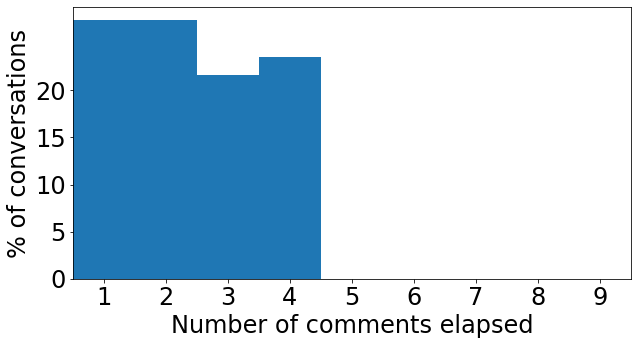

In [29]:
# visualize the distribution of "number of comments until derailment" as a histogram (reproducing Figure 4 from the paper)
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 24
plt.hist(comments_until_derail_vals, bins=range(1, np.max(comments_until_derail_vals)), density=True)
plt.xlim(1,10)
plt.xticks(np.arange(1,10)+0.5, np.arange(1,10))
plt.yticks(np.arange(0,0.25,0.05), np.arange(0,25,5))
plt.xlabel("Number of comments elapsed")
plt.ylabel("% of conversations")
plt.show()